# Smart Housing Advisor
Tri Blankley and Kassidy Maberry

2025/05/06

Data provided by Redfin, a national real estate brokerage.

Link: https://www.redfin.com/news/data-center

In [1]:
import pandas as pd
import matplotlib.pyplot as mlp
import seaborn as sb
import plotly.express as px

# For rendering plotly graphs
import plotly.io as pio
pio.renderers.default = 'iframe'


"""
Loads plot data.
"""
def load_data():
    d = pd.read_csv("city_market_tracker.tsv000", sep="\t")
    d["PERIOD_BEGIN"] = pd.to_datetime(d["PERIOD_BEGIN"])
    d["PERIOD_END"] = pd.to_datetime(d["PERIOD_END"])
    return d

data = load_data()
print("Data has loaded")

Data has loaded


# Task 1: User Input

In [2]:
income = float(input("Enter your annual income: "))
downPay = float(input("Enter your down payment: "))

Enter your annual income:  32000
Enter your down payment:  2000


# Task 2: Affordability Estimation

In [3]:
monthlyBudget = (income * .3)/12
loanDur = int(input("Enter a loan duration in months: "))
# Predicts via loan duration and 30% of your monthly income. No interest is assumed.
houseBudget = downPay + monthlyBudget * loanDur
out = data[data["MEDIAN_SALE_PRICE"] <= houseBudget]
out = out[["MEDIAN_SALE_PRICE", "CITY"]]
print("You can afford houses from the following cities.")
print(out)

Enter a loan duration in months:  60


You can afford houses from the following cities.
         MEDIAN_SALE_PRICE             CITY
103                35777.0       Hartshorne
107                20000.0  Cedar Glen West
108                19109.0       Hagerstown
110                20000.0    Fairmont City
117                32750.0         Bellaire
...                    ...              ...
5818610            35500.0      Marine City
5818620            31450.0           Elnora
5818656            18000.0     Sylvan Beach
5818678            49550.0    Richmondville
5818729            43000.0           Ashley

[251170 rows x 2 columns]


# Task 3: Market Trend Analysis

Enter your prefered city (optional):  Chicago


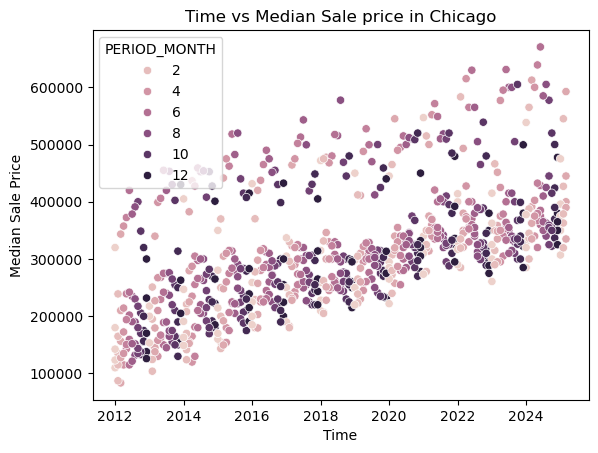

In [4]:
city = input("Enter your prefered city (optional): ")
market = data[data["CITY"] == city]
if market.size == 0:
    print("Unknown city defaulting to all")
    market = data
    city = ""
else:
    city = " in " + city

market.insert(1, "PERIOD_YEAR", market["PERIOD_BEGIN"].dt.year)
market.insert(1, "PERIOD_MONTH", market["PERIOD_BEGIN"].dt.month)
sb.scatterplot(market, x="PERIOD_BEGIN", y="MEDIAN_SALE_PRICE", hue="PERIOD_MONTH")
mlp.xlabel("Time")
mlp.ylabel("Median Sale Price")
mlp.title(f"Time vs Median Sale price{city}")
mlp.show()

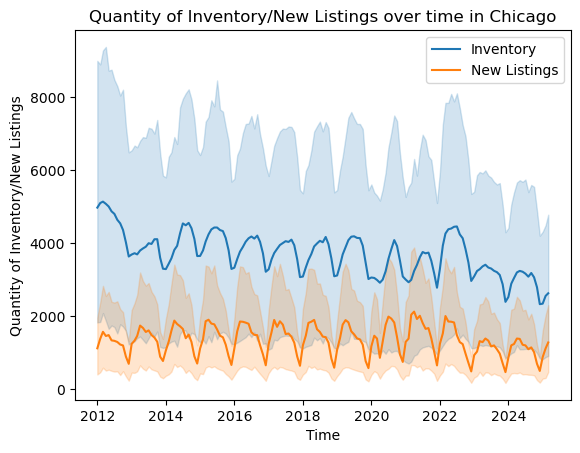

In [5]:
sb.lineplot(market, x="PERIOD_BEGIN", y="INVENTORY", label="Inventory")
sb.lineplot(market, x="PERIOD_BEGIN", y="NEW_LISTINGS", label="New Listings")
mlp.ylabel("Quantity of Inventory/New Listings")
mlp.xlabel("Time")
mlp.title(f"Quantity of Inventory/New Listings over time{city}")
mlp.show()

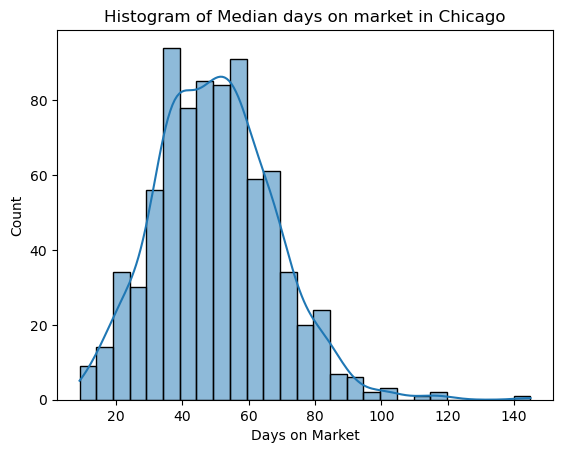

In [6]:
sb.histplot(market, x="MEDIAN_DOM", kde=True)
mlp.title(f"Histogram of Median days on market{city}")
mlp.xlabel("Days on Market")
mlp.show()

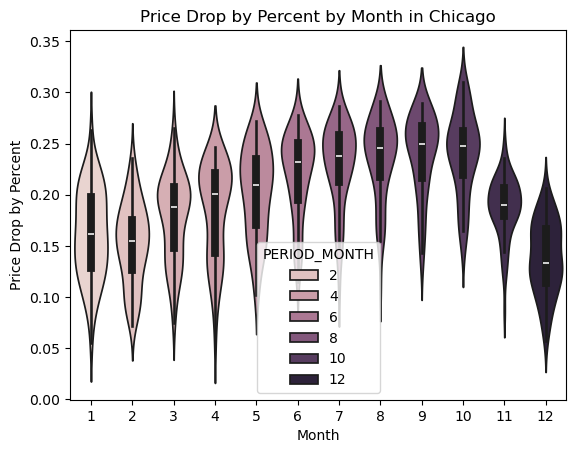

In [7]:
sb.violinplot(market, x="PERIOD_MONTH", y="PRICE_DROPS", hue="PERIOD_MONTH")
mlp.title(f"Price Drop by Percent by Month{city}")
mlp.xlabel("Month")
mlp.ylabel("Price Drop by Percent")
mlp.show()

In [8]:
# WARNING THIS WILL MAKE JUPYTER VERY UNSTABLE
houses = data[data["MEDIAN_SALE_PRICE"] <= houseBudget]
q = data.groupby("CITY")["MEDIAN_SALE_PRICE"].agg('mean')
q = q.reset_index()
states = houses[["CITY", "STATE"]]

q = pd.merge(q, states, left_on="CITY", right_on="CITY")
q = q.drop_duplicates()
fig = px.bar(q, x="MEDIAN_SALE_PRICE", y="CITY", title="City To Median House Price", color="STATE")
fig.show()

# Task 4: Generate Insights

In [9]:
# Estimagted cost of house within your budget -----------------------------------------------------------------------
print(f"Your estimated house budget is ${houseBudget}")

out = data[data["MEDIAN_SALE_PRICE"] <= houseBudget]
out = out[["CITY", "STATE_CODE"]]
vals = out.values
val = int(input("How many cities do you want to print?"))
i = 0
print("Places that fit your budget:")
for c in vals:
    if i == val:
        break
    print(f"- {c[0]}, {c[1]}")
    i += 1

if i == 0:
    print("We searched far and wide but no cities fit your budget.")

# Show cities where the price of houses is falling ----------------------------------------------------------------
# Group data by city and get the first and last median sale prices
# Where a period is given for the time differnce of house value
price_trends = data.sort_values(by="PERIOD_BEGIN").groupby("CITY").agg(
    first_price=("MEDIAN_SALE_PRICE", "first"),
    last_price=("MEDIAN_SALE_PRICE", "last")
)
# Add price trends to dataset for printing and sorting vlaues
price_trends["price_change"] = price_trends["last_price"] - price_trends["first_price"]
price_trends["price_change_pct"] = 100 * price_trends["price_change"] / price_trends["first_price"]


print(f"Top {val} cities by highest price change:")
print("Places with lowest prices.")
price_trends = price_trends.sort_values(by="price_change_pct")
price_trends = price_trends.reset_index()
price_drops = price_trends[["CITY", "price_change_pct"]]
i = 0 
for c in price_drops.values:
    if i == val:
        break
    print(f"It is a good time to invest in {c[0]} prices have dropped {c[1]}%")
    i += 1

print("Places with highest prices.")
price_drops = price_drops.sort_values(by="price_change_pct", ascending=False)
i = 0
for c in price_drops.values:
    if i == val:
        break
    print(f"Avoid {c[0]} with your wallet, prices have increased {c[1]}%")
    i += 1


# City where you have the most time to deleberate on the house purchase -----------------------------------------
# Find the most recent period for each city
latest_dom_dates = data.groupby("CITY")["PERIOD_BEGIN"].max().reset_index()
latest_dom_data = data.merge(latest_dom_dates, on=["CITY", "PERIOD_BEGIN"], how="inner")
latest_dom_data = latest_dom_data.dropna(subset=["MEDIAN_DOM"])
# Sort by highest dom.
latest_dom_data = latest_dom_data.sort_values(by="MEDIAN_DOM", ascending=False)
print(f"Top {val} Cities with highest DOM")
dom_data = latest_dom_data[["CITY", "MEDIAN_DOM"]]
dom_data = dom_data.drop_duplicates()
print(dom_data.head(val))


# Show the best city for a given property type -------------------------------------------------------------
# Display each property type.
property_types = data["PROPERTY_TYPE"].unique()
print("Available Property Types:")
for property_type in property_types:
    print(f"- {property_type}")

property_type = input("Enter the desired property type (e.g., 'Single Family Residential', 'Condo/Co-op', etc.): ")

# The great filtering counter
property_data = data[data["PROPERTY_TYPE"] == property_type]
property_count_by_city = property_data.groupby("CITY")["PROPERTY_TYPE"].count().reset_index()
property_count_by_city = property_count_by_city.rename(columns={"PROPERTY_TYPE": "listing_count"})
property_count_by_city = property_count_by_city.sort_values(by="listing_count", ascending=False)

print(f"Top {val} Cities you may be interested in with the most {property_type} listings:")
print(property_count_by_city.head(val))

Your estimated house budget is $50000.0


How many cities do you want to print? 5


Places that fit your budget:
- Hartshorne, OK
- Cedar Glen West, NJ
- Hagerstown, IN
- Fairmont City, IL
- Bellaire, OH
Top 5 cities by highest price change:
Places with lowest prices.
It is a good time to invest in Johnsonburg prices have dropped -97.22222222222223%
It is a good time to invest in Cut Off prices have dropped -96.9047619047619%
It is a good time to invest in Windsor prices have dropped -95.39682539682539%
It is a good time to invest in Hardesty prices have dropped -95.38461538461539%
It is a good time to invest in Belle Vernon prices have dropped -94.86404833836858%
Places with highest prices.
Avoid Stinesville with your wallet, prices have increased 16699900.0%
Avoid Mesa Verde with your wallet, prices have increased 9999900.0%
Avoid Wurtland with your wallet, prices have increased 9449900.0%
Avoid McKnightstown with your wallet, prices have increased 36400.0%
Avoid Beverly Hills with your wallet, prices have increased 26494.444444444445%
Top 5 Cities with highest DOM


Enter the desired property type (e.g., 'Single Family Residential', 'Condo/Co-op', etc.):  Condo/Co-op


Top 5 Cities you may be interested in with the most Condo/Co-op listings:
             CITY  listing_count
5838  Springfield            893
759    Burlington            861
3873      Milford            842
3266     Lakewood            837
3864   Middletown            826
